In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
from sklearn.cluster import KMeans
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_palette('husl')

In [3]:
minn = io.loadmat('../data/minnesota.mat')
Aroads = minn['Problem'][0][0][2]
xy = minn['Problem'][0][0][8][0][0][0]

numcomp, components = csgraph.connected_components(Aroads)
compsize = np.max(np.bincount(components))
biggestcomp = np.argmax(np.bincount(components))
in_component = np.where(components == biggestcomp)[0]

Aroads = Aroads.todense()
Aroads = Aroads[in_component][:, in_component]
Aroads = sparse.csc_matrix(Aroads)

xy = xy[in_component]

links = np.where(Aroads.todense())
startcoords = xy[links[0]]
endcoords = xy[links[1]]
lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

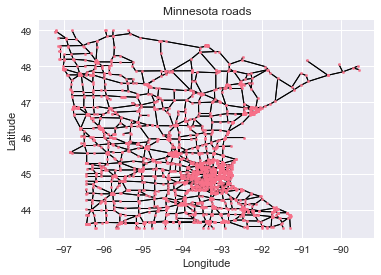

In [4]:
fig, ax = plt.subplots()

lc = collections.LineCollection(lines, linewidths=1, colors='k')

ax.add_collection(lc)
ax.scatter(xy[:, 0], xy[:, 1], s=6, zorder=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Minnesota roads')

# Spectral clustering

In [5]:
# Compute graph laplacian and determine eigendecomposition
L = csgraph.laplacian(Aroads)
L = L.todense()
l, u = np.linalg.eigh(L)

# Perform k-means clustering on eigenvectors of L
k = 4
kmeans = KMeans(n_clusters=k, random_state=0).fit(u[:, :k])
g = kmeans.labels_

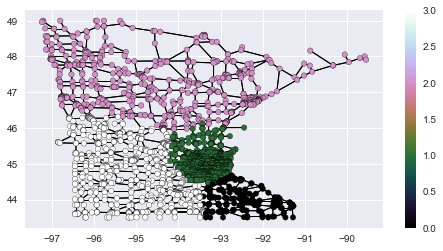

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[:, 0], xy[:, 1], s=30, c=g, alpha=1,
                zorder=2, cmap='cubehelix', vmin=g.min(), vmax=g.max(), edgecolor='k')
plt.colorbar(sc, ax=ax)

# Recursive spectral bisection

In [7]:
def partition_graph(A, ix=[]):
    L = csgraph.laplacian(A)
    l, u = sparse.linalg.eigsh(L, k=2, which='SM')
    sgn = np.sign(np.asarray(u[:, 1]).ravel())
    ixpos = np.where(sgn == 1)[0].astype(int)
    ixneg = np.where(sgn == -1)[0].astype(int)
    if (len(ix) != 0):
        ixpos = ix[ixpos]
        ixneg = ix[ixneg]
    Apos = A[sgn == 1, :][:, sgn == 1]
    Aneg = A[sgn == -1, :][:, sgn == -1]
    return (Apos, Aneg), (ixpos, ixneg)

def partition_recurse(data, count, ix=[]):
    if (count == 0):
        return data, ix
    count -= 1
    new_data = []
    new_ixes = []
    if not isinstance(data, list):
        data = [data]
    for data_i, ix_i in itertools.zip_longest(data, ix, fillvalue=[]):
        As, ixes = partition_graph(data_i, ix_i)
        new_data.extend(As)
        new_ixes.extend(ixes)
    return partition_recurse(new_data, count, new_ixes)

In [8]:
a1, i1 = partition_recurse(Aroads, 1)

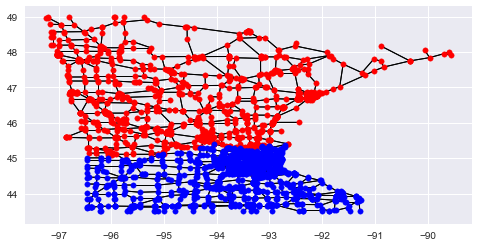

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[i1[0], 0], xy[i1[0], 1], s=30, c='r', alpha=1,
                zorder=2)
sc = ax.scatter(xy[i1[1], 0], xy[i1[1], 1], s=30, c='b', alpha=1,
                zorder=2)

In [10]:
a2, i2 = partition_recurse(Aroads, 2)

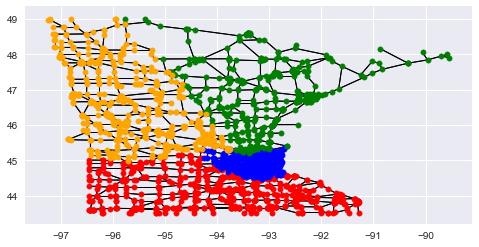

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[i2[0], 0], xy[i2[0], 1], s=30, c='red', alpha=1,
                zorder=2)
sc = ax.scatter(xy[i2[1], 0], xy[i2[1], 1], s=30, c='blue', alpha=1,
                zorder=2)
sc = ax.scatter(xy[i2[2], 0], xy[i2[2], 1], s=30, c='green', alpha=1,
                zorder=2)
sc = ax.scatter(xy[i2[3], 0], xy[i2[3], 1], s=30, c='orange', alpha=1,
                zorder=2)